# Synthesizing Data 
## By: Lela Bones
-----------------------------------
### Problem
    Nestor is an application that allows users to datify their maintenance logs. Datify is the process of taking unorginized data and putting it into a quantifiable and statistically relevant format. The problem is that because of copywright and data ownership technicalities, it is hard for us to have a large amount of "good" data to demo our app on. 

### Solution
    I plan on using Reccurent Neural Nets (RNNs) to generate realistic data from the data that we already have from companies. The reason for this is because we can use the "synthetic" data to demo our app on, and we aren't breaking any laws. I plan on using a Python library, Pytorch to implement my RNN and train it on the data. 

#### Why Pytorch???
Pytorch is a framework that builds from the Torch framework that Facebook actively uses. Pytorch is extremely fast it is very native and customizable. Pytorch is also a dynamic deep learning tool, which means that you can change and execute notes as you're learning. This makes RNNs way easier to train because you don't need to set a maximum length and then pad smaller sequences. Debugging is really easy because it is defined at runtime. It works well with Flask, which is the tool that I am using to create my visual dashboard. Pytorch also has declarative data parallelism which allows you to use multiple GPUs. 

#### Why RNNs???
    * Vanilla Neural Networks relearn each iteration
    * Long Short Term Memory Neural Nets are good for long-term data
    * Maybe GRU Neural Nets, they get rid of the disappearing gradient problem
    * RNNs implement loops so the learning is compositional

### Data manipulation

In [1]:
#conda install pandas
#conda install pytorch torchvision -c pytorch
#conda install numpy
import pandas as pd
import torch
import numpy as np

In [2]:
#set data file, column you want extracted, and output file
csv_file = 'mine_raw.csv'
txt_file = 'train.txt'
text_col = 'OriginalShorttext'

In [3]:
#this function converts the column of text from your csv file 
#to a text file that has each row on a seperate line
#code modified from https://stackoverflow.com/questions/47339698/how-to-convert-csv-file-to-text-file-using-python
def createTextFile(inputFile, text, outputFile):
    df = pd.read_csv(inputFile)
    data = df[text].apply(lambda x: " ".join(x.lower() for x in x.split()))

    text_list = []
    for line in data:
        text_list.append(" ".join(line))
    
    #switch to a+ if you want to append to existing file
    with open(outputFile, "w+") as output_file:
        for line in data:
            output_file.write("  " + line + "\n")
        #verification that it's finished
        print('File Successfully written.')
    output_file.close()

In [4]:
createTextFile(csv_file, text_col, txt_file)

File Successfully written.


## First Attempt
The majority of this code was modified from https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb


In [5]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open(txt_file).read())
file_len = len(file)
print('file_len =', file_len)

file_len = 165817


In [6]:
chunk_len = 200

#splitting up the code into random chunks each the size of 200
def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

# print(random_chunk())

### Creating the Neural Net

In [7]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [8]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([ 10,  11,  12,  39,  40,  41])


In [9]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [10]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [11]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

In [13]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

/home/msid/ltb3/anaconda3/envs/nestorDev/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


 37s (100 5%) 1.8912]
Wh6KR6h6HLB
  rick trotstho
  don leakin ol tup stir takt alg bo r/h oling
  wir ang sil wrepam moan n 

 19s (200 10%) 2.0013]
Whss on woth shyd 24104
  replace hose line hose out
  replh r/h prepace line l/h  hyd liling l/h buck 

 56s (300 15%) 1.4132]
Whand motoat switexs
  harmids leak ~ rh engine pump
  replace ~ talank leaking leake)
  replace chang 

 35s (400 20%) 1.1199]
Whk mairs
  repair repair bucket start toom hfidys
  al bext oils not working
  reasre looth over toor 

 18s (500 25%) 1.1332]
Wh hand ring ousing aproken eal shd24
  replace boom alant
  replace arem fileget filtern pressins
  r 

 1s (600 30%) 1.0488]
Wh slew bot on bolts oulter start under
  cramp broken grease shd 4 replace coor 4
  replace for ganer 

 44s (700 35%) 1.4145]
Wh bucket top
  rh alarr shd24.
  repair and shd0024
  repair bucket tooth
  repair aday grease
  repa 

 19s (800 40%) 1.2525]
Wh fire rimessor wofff pump senters
  replace block in creplaces splate ring
  wate

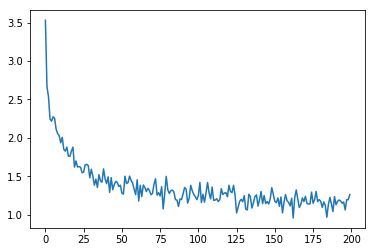

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Second Attempt
Most of this code is from https://github.com/mcleonard/pytorch-charRNN/blob/master/TorchRNN.ipynb

In [5]:
#importing necessary libraries
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

In [6]:
#read in data
with open (txt_file, 'r') as f:
    text = f.read()

In [7]:
#convert char to int
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}
encoded = np.array([char2int[ch] for ch in text])

In [8]:
def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns mini-batches of size
       n_seqs x n_steps from arr.
    '''
    
    batch_size = n_seqs * n_steps
    n_batches = len(arr)//batch_size
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size]
    # Reshape into n_seqs rows
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:, n:n+n_steps]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+n_steps]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [9]:
class CharRNN(nn.Module):
    def __init__(self, tokens, n_steps=100, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        self.dropout = nn.Dropout(drop_prob)
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(n_hidden, len(self.chars))
        
        self.init_weights()
        
    def forward(self, x, hc):
        ''' Forward pass through the network '''
        
        x, (h, c) = self.lstm(x, hc)
        x = self.dropout(x)
        
        # Stack up LSTM outputs
        x = x.view(x.size()[0]*x.size()[1], self.n_hidden)
        
        x = self.fc(x)
        
        return x, (h, c)
    
    def predict(self, char, h=None, cuda=False, top_k=None):
        ''' Given a character, predict the next character.
        
            Returns the predicted character and the hidden state.
        '''
        if cuda:
            self.cuda()
        else:
            self.cpu()
        
        if h is None:
            h = self.init_hidden(1)
        
        x = np.array([[self.char2int[char]]])
        x = one_hot_encode(x, len(self.chars))
        inputs = Variable(torch.from_numpy(x), volatile=True)
        if cuda:
            inputs = inputs.cuda()
        
        h = tuple([Variable(each.data, volatile=True) for each in h])
        out, h = self.forward(inputs, h)

        p = F.softmax(out).data
        if cuda:
            p = p.cpu()
        
        if top_k is None:
            top_ch = np.arange(len(self.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
            
        return self.int2char[char], h
    
    def init_weights(self):
        ''' Initialize weights for fully connected layer '''
        initrange = 0.1
        
        # Set bias tensor to all zeros
        self.fc.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc.weight.data.uniform_(-1, 1)
        
    def init_hidden(self, n_seqs):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        return (Variable(weight.new(self.n_layers, n_seqs, self.n_hidden).zero_()),
                Variable(weight.new(self.n_layers, n_seqs, self.n_hidden).zero_()))

In [10]:
def train(net, data, epochs=10, n_seqs=10, n_steps=50, lr=0.001, clip=5, val_frac=0.1, cuda=False, print_every=10):
    ''' Traing a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        n_seqs: Number of mini-sequences per mini-batch, aka batch size
        n_steps: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        cuda: Train with CUDA on a GPU
        print_every: Number of steps for printing training and validation loss
    
    '''
    
    net.train()
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if cuda:
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    for e in range(epochs):
        h = net.init_hidden(n_seqs)
        for x, y in get_batches(data, n_seqs, n_steps):
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            x, y = torch.from_numpy(x), torch.from_numpy(y)
            
            inputs, targets = Variable(x), Variable(y)
            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([Variable(each.data) for each in h])

            net.zero_grad()
            
            output, h = net.forward(inputs, h)
            loss = criterion(output, targets.view(n_seqs*n_steps))

            loss.backward()
            
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm(net.parameters(), clip)

            opt.step()
            
            if counter % print_every == 0:
                
                # Get validation loss
                val_h = net.init_hidden(n_seqs)
                val_losses = []
                for x, y in get_batches(val_data, n_seqs, n_steps):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([Variable(each.data, volatile=True) for each in val_h])
                    
                    inputs, targets = Variable(x, volatile=True), Variable(y, volatile=True)
                    if cuda:
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net.forward(inputs, val_h)
                    val_loss = criterion(output, targets.view(n_seqs*n_steps))
                
                    val_losses.append(val_loss.data[0])
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.data[0]),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [ ]:
if 'net' in locals():
    del net



net = CharRNN(chars, n_hidden=795, n_layers=3)

n_seqs, n_steps = 128, 100
train(net, encoded, epochs=25, n_seqs=200, n_steps=160, lr=0.001, cuda=False, print_every=10)

/home/msid/ltb3/anaconda3/envs/nestorDev/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/msid/ltb3/anaconda3/envs/nestorDev/lib/python3.6/site-packages/ipykernel_launcher.py:74: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/msid/ltb3/anaconda3/envs/nestorDev/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/msid/ltb3/anaconda3/envs/nestorDev/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/msid/ltb3/anaconda3/envs/nestorDev/lib/python3.6/site-packages/ipykernel_launcher.py:87: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. U

Epoch: 1/25... Step: 10... Loss: 3.4990... Val Loss: 3.4705
Epoch: 1/25... Step: 20... Loss: 3.0711... Val Loss: 3.3570
Epoch: 1/25... Step: 30... Loss: 3.1354... Val Loss: 3.1969
Epoch: 1/25... Step: 40... Loss: 2.0497... Val Loss: 3.0917
Epoch: 1/25... Step: 50... Loss: 2.1963... Val Loss: 3.0905
Epoch: 1/25... Step: 60... Loss: 2.5658... Val Loss: 2.9211
Epoch: 1/25... Step: 70... Loss: 2.8160... Val Loss: 3.1486
Epoch: 1/25... Step: 80... Loss: 1.6296... Val Loss: 3.0910
Epoch: 1/25... Step: 90... Loss: 2.0576... Val Loss: 2.9641
Epoch: 1/25... Step: 100... Loss: 1.5698... Val Loss: 2.9413
Epoch: 1/25... Step: 110... Loss: 1.1244... Val Loss: 2.9723
Epoch: 1/25... Step: 120... Loss: 2.5040... Val Loss: 3.1286
Epoch: 1/25... Step: 130... Loss: 1.1422... Val Loss: 2.9360
Epoch: 1/25... Step: 140... Loss: 1.1540... Val Loss: 2.8554
Epoch: 1/25... Step: 150... Loss: 2.2376... Val Loss: 3.1941
Epoch: 1/25... Step: 160... Loss: 1.6501... Val Loss: 2.7525
Epoch: 1/25... Step: 170... Loss:

Epoch: 1/25... Step: 1350... Loss: 1.6789... Val Loss: 2.2079
Epoch: 1/25... Step: 1360... Loss: 2.5328... Val Loss: 2.1861
Epoch: 1/25... Step: 1370... Loss: 1.3819... Val Loss: 2.1603
Epoch: 1/25... Step: 1380... Loss: 1.3821... Val Loss: 2.1477
Epoch: 1/25... Step: 1390... Loss: 1.5764... Val Loss: 2.1726
Epoch: 1/25... Step: 1400... Loss: 1.1424... Val Loss: 2.2661
Epoch: 1/25... Step: 1410... Loss: 1.5617... Val Loss: 2.1868
Epoch: 1/25... Step: 1420... Loss: 1.0465... Val Loss: 2.1794
Epoch: 1/25... Step: 1430... Loss: 0.7897... Val Loss: 2.1808
Epoch: 1/25... Step: 1440... Loss: 0.5123... Val Loss: 2.2531
Epoch: 1/25... Step: 1450... Loss: 1.2089... Val Loss: 2.1924
Epoch: 1/25... Step: 1460... Loss: 1.0201... Val Loss: 2.2093
Epoch: 1/25... Step: 1470... Loss: 1.5734... Val Loss: 2.1409
Epoch: 1/25... Step: 1480... Loss: 2.0174... Val Loss: 2.1182
Epoch: 1/25... Step: 1490... Loss: 0.9649... Val Loss: 2.1573
Epoch: 1/25... Step: 1500... Loss: 1.5990... Val Loss: 2.1786
Epoch: 1

Epoch: 1/25... Step: 2680... Loss: 2.2113... Val Loss: 1.9035
Epoch: 1/25... Step: 2690... Loss: 2.6922... Val Loss: 1.8731
Epoch: 1/25... Step: 2700... Loss: 1.7524... Val Loss: 1.8734
Epoch: 1/25... Step: 2710... Loss: 1.0603... Val Loss: 1.8496
Epoch: 1/25... Step: 2720... Loss: 0.6981... Val Loss: 1.8546
Epoch: 1/25... Step: 2730... Loss: 1.3079... Val Loss: 1.9394
Epoch: 1/25... Step: 2740... Loss: 1.6397... Val Loss: 1.8733
Epoch: 1/25... Step: 2750... Loss: 1.3436... Val Loss: 1.8694
Epoch: 1/25... Step: 2760... Loss: 1.4824... Val Loss: 1.8918
Epoch: 1/25... Step: 2770... Loss: 1.3203... Val Loss: 1.9477
Epoch: 1/25... Step: 2780... Loss: 1.3626... Val Loss: 1.8886
Epoch: 1/25... Step: 2790... Loss: 1.3850... Val Loss: 1.8939
Epoch: 1/25... Step: 2800... Loss: 1.7738... Val Loss: 1.9232
Epoch: 1/25... Step: 2810... Loss: 1.1604... Val Loss: 1.9366
Epoch: 1/25... Step: 2820... Loss: 1.4819... Val Loss: 1.9691
Epoch: 1/25... Step: 2830... Loss: 1.2749... Val Loss: 1.9534
Epoch: 1

In [12]:
checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars}
with open('rnn.net', 'wb') as f:
    torch.save(checkpoint, f)

In [13]:
def sample(net, size, prime='The', top_k=None, cuda=False):
        
    if cuda:
        net.cuda()
    else:
        net.cpu()

    net.eval()
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = net.predict(ch, h, cuda=cuda, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = net.predict(chars[-1], h, cuda=cuda, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [19]:
print(sample(net, 20000, prime='the', top_k=10, cuda=False))

/home/msid/ltb3/anaconda3/envs/nestorDev/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/msid/ltb3/anaconda3/envs/nestorDev/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/msid/ltb3/anaconda3/envs/nestorDev/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


thel on stoem
  repair hre line of sensticy
  loose cys.dr2 sidarn on lube sha24.
  repair leak on atarbo
  grease lont handranigel boom
  leaking lose stor hyd hose
  replace lh braken tooth
  replace bucket she tooth
  lep. sod lost ref replace tooth
  replace bucket teet
  chs taint ox bucket tin
  stait light on bucket tooth
  replace movol lh rh ro-llak hoses.
  replace fault rh engineo
  replace sliw hoserssion
  repair hid ressuil famind tor
  host.. poned tavel sed refint replaces
  broken grease line on bucket teet
  replace lh prh pump change fie lefters
  crack ater hip in bucket toothr low
  hyd lows
  low low hose
  replace hydraulic line
  boom filt on bucket out
  leakinagr leaks on bucket on boom
  replace missing bump engine scab tool loss
  repair on lh eaging shprouns
  replace supper grease ligh shd24
  repair hreadar out
  rh engine breat hag deming at entine
  changeout l fint on chackend
  will not radirouts
  leatitor rigen swing hydraulic oil
  blownny reslace 

In [ ]:
with open('rnn.net', 'rb') as f:
    checkpoint = torch.load(f)
    
loaded = CharRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])

In [ ]:
print(sample(loaded, 2000, cuda=False, top_k=5, prime="replace"))